In [1]:
#Shengchao, Juan 
#Apr.2021
#v1.1
#
#Edited by Aidan, added multiple iterations
#Jun.2021
#July 15, new version, Juan, adding multiple iterations in multiple channels, cleaning the code


import numpy as np
import pandas as pd
import scipy
import scipy.stats
import scipy.optimize as op
from scipy.optimize import curve_fit
import os
from scipy.integrate import quad 
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
#from multihist import Histdd


import time
import sys
import tqdm

import math
import random
import numba

from scipy.stats import norm

import struct

In [2]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [88]:
#read file for multiple channels
channels=8
dmafiforeq=16382 #requested number of elements of the dma fifo in the PC code, set to 2xDMA FIFO depth
iterations=1000 #number of iterations of the PC code, if labview says x iterations, there are x+1
fileName = '/project/darkmatters/WINDCHIME/Protochime_data/8chan.dat'
data_raw = numpy.fromfile(fileName, dtype="<i2") #> for big endian, < for little, i2 for signed integer of 2 bytes=16 bits
print("binary file received is size "+str(data_raw.shape[0]))
#create matrix where each column is an iteration
if data_raw.shape[0]%iterations!=0:
    print('warning: each iteration does not have the requested number of elements')
iter_matrix=np.reshape(data_raw,(iterations,int(data_raw.shape[0]/iterations)))
iter_matrix=np.delete(iter_matrix,(0,1,2,3), axis=1) #deleting first 4 columns, which is the 4 value header {channels,0,dmafiforeq,0} at the beginning of an iteration 
#creating one array per channel: first 65534*(x+1) elements in each row corresponds to channel x, x from 0 to channels


temp0=np.reshape(iter_matrix[:,0:dmafiforeq],(1,dmafiforeq*iterations))
temp1=np.reshape(iter_matrix[:,dmafiforeq:2*dmafiforeq],(1,dmafiforeq*iterations))
temp2=np.reshape(iter_matrix[:,2*dmafiforeq:3*dmafiforeq],(1,dmafiforeq*iterations))
temp3=np.reshape(iter_matrix[:,3*dmafiforeq:4*dmafiforeq],(1,dmafiforeq*iterations))
temp4=np.reshape(iter_matrix[:,4*dmafiforeq:5*dmafiforeq],(1,dmafiforeq*iterations))
temp5=np.reshape(iter_matrix[:,5*dmafiforeq:6*dmafiforeq],(1,dmafiforeq*iterations))
temp6=np.reshape(iter_matrix[:,6*dmafiforeq:7*dmafiforeq],(1,dmafiforeq*iterations))
temp7=np.reshape(iter_matrix[:,7*dmafiforeq:8*dmafiforeq],(1,dmafiforeq*iterations))


channels=np.transpose(np.array([temp0[0],temp1[0],temp2[0],temp3[0],temp4[0],temp5[0],temp6[0],temp7[0]])) #1 channel per column
print(np.shape(channels))

data=pd.DataFrame(channels, columns=None) #channel 1 is labeled as 0, channel n is labeled as n-1

binary file received is size 131060000
(16382000, 8)


,0,1,2,3
0,-0.324956,-0.023926,-0.025269,-0.019165
1,-0.326665,-0.023926,-0.025269,-0.019165
2,-0.327398,-0.023682,-0.025391,-0.019043
3,-0.328374,-0.023560,-0.025269,-0.019043
4,-0.328985,-0.024048,-0.025147,-0.018799
...,...,...,...,...
6553395,-0.183719,-0.023560,-0.025269,-0.018921
6553396,-0.178836,-0.023682,-0.025391,-0.019165
6553397,-0.173587,-0.023926,-0.025391,-0.018921
6553398,-0.169070,-0.023926,-0.025147,-0.019043


In [89]:
sample_freq = 2.5  #MHz
data['time_us']= 1/sample_freq*data.index #us

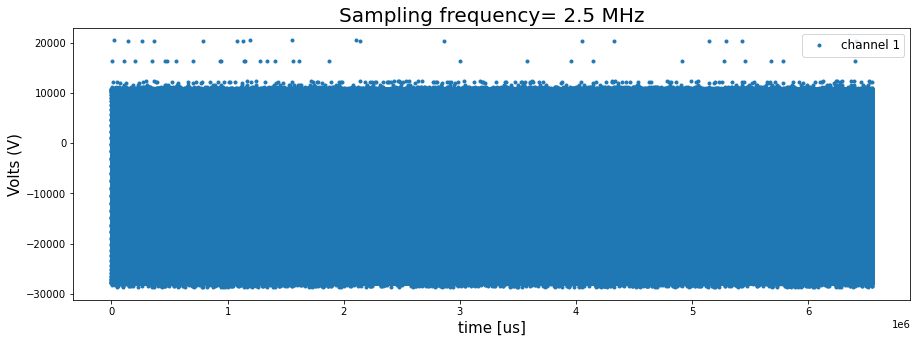

In [92]:
start=0#len(data[0])-600
end=len(data[0])
plt.figure(figsize=(15,5))
plt.title("Sampling frequency= "+str(sample_freq)+" MHz",size=20)

plt.plot(data['time_us'][start:end],data[0][start:end],label='channel 1',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[1],label='channel 2',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[2],label='channel 3',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[3],label='channel 4',marker='.',linestyle='none')

plt.ylabel('Volts (V)',size=15)
plt.xlabel('time [us]',size=15)

#fit_result= fit_sin(data['time_us'],data[0])
#sin_func=fit_result['fitfunc']

#plt.plot(data['time_us'][start:end],sin_func(data['time_us'][start:end]), label='fitted frequency and Amplitude=%.3f kHz, %.3f V'%(fit_result['freq']*1000,fit_result['amp']))
plt.legend(fontsize=12, loc='best')
#plt.ylim([-0.5,0.01])
plt.show()

In [25]:
#number of peaks found vs expected
start=0
end=len(data[0])
fit_result= fit_sin(data['time_us'][start:end],data[0][start:end])
sin_func=fit_result['fitfunc']
import scipy.signal
peaks=scipy.signal.find_peaks(sin_func(data['time_us'][start:end]))
number_found=len(peaks[0])
#print(peaks,number_found)

In [26]:
input_freq=30101.5 #Hz or cycles per sec
sampling_points=np.shape(channels)[0] #per channel
sampling_freq=2500000#clock rate in LabView FPGA
number_expected=sampling_points*input_freq/sampling_freq
print(number_expected)
cycles_lost=abs(number_expected-number_found)
print(cycles_lost)

789068.6804
0.6803999999538064


In [27]:
#points lost in the acquiring process: each cycle takes 1/freq seconds to happen, and we take sampling_rate data points per second
points_lost=cycles_lost*sampling_freq/input_freq
print(points_lost)

56.50881184939342


In [ ]:
#first peak
first_pk=peaks[0][0]
last_pk=peaks[0][-1]
points_between=last_pk-first_pk


(array([4.252000e+03, 6.500000e+01, 1.826210e+05, 5.551646e+06,
        2.787276e+06, 2.012738e+06, 1.769559e+06, 1.480276e+06,
        1.422663e+06, 1.271905e+06, 1.253304e+06, 1.103824e+06,
        1.127578e+06, 1.050117e+06, 1.075237e+06, 9.782510e+05,
        9.404620e+05, 9.688560e+05, 8.794060e+05, 9.105160e+05,
        8.610960e+05, 9.132830e+05, 8.615320e+05, 9.237610e+05,
        8.677990e+05, 9.038770e+05, 8.632330e+05, 9.021740e+05,
        8.469210e+05, 9.261360e+05, 8.641990e+05, 9.028610e+05,
        8.563580e+05, 8.672710e+05, 9.160180e+05, 8.960900e+05,
        9.753110e+05, 9.758630e+05, 1.053447e+06, 1.027815e+06,
        1.078407e+06, 1.060109e+06, 1.192193e+06, 1.198456e+06,
        1.322054e+06, 1.340101e+06, 1.562003e+06, 1.668474e+06,
        2.117872e+06, 2.622857e+06, 5.209429e+06, 8.298600e+04,
        1.242000e+03, 8.100000e+01, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

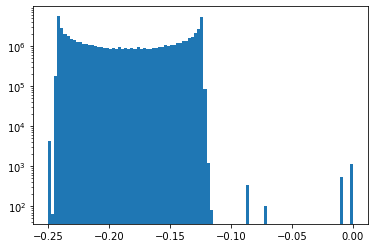

In [29]:
plt.hist(x = data[0][100000:], bins = 100, log = True)

In [31]:
a = [1,2,3,2]
for f in a:
    print(a.index(f))

0
1
2
1


In [30]:
print(2**13)

8192
